In [16]:
import os
import sys
# Add current directory to path
sys.path.append(os.path.dirname(os.getcwd()))
import Mulguisin

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [18]:
hdul = fits.open("../HectoMAP/HectoMAP_DR16_spec23.fits")
data = hdul[1].data
hdul.close()

# Extract columns
ra_value = data['Z_RA'].astype(np.float64)
dec_value = data['Z_DEC'].astype(np.float64)
z_value = data['Z_TOT_Z'].astype(np.float64)

print("Total raw entries:", len(ra_value))

Total raw entries: 1148697


In [20]:
# STRICT Filter: Remove stars (z<0.01) and sparse regions (z>0.6)
valid_mask = (z_value > 0.01) & (z_value < 0.6) & np.isfinite(z_value) & \
             (ra_value > 0) & (ra_value < 360) & (dec_value > -90) & (dec_value < 90)

ra_valid = ra_value[valid_mask]
dec_valid = dec_value[valid_mask]
z_valid = z_value[valid_mask]

print(f"Valid galaxies after filtering: {len(ra_valid)}")

Valid galaxies after filtering: 98175


In [28]:
c = 3e5
H0 = 70.0

# 1. Physical Distance (Mpc) - For Topology/Links
dist_mpc = (z_valid * c) / H0

# 2. Recessional Velocity (km/s) - For Finger of God Check
recessional_vel = z_valid * c

# Convert RA/Dec to Cartesian (Mpc)
ra_rad = np.deg2rad(ra_valid)
dec_rad = np.deg2rad(dec_valid)

x_mpc = dist_mpc * np.cos(dec_rad) * np.cos(ra_rad)
y_mpc = dist_mpc * np.cos(dec_rad) * np.sin(ra_rad)
z_mpc = dist_mpc * np.sin(dec_rad)

x_mpc, y_mpc, z_mpc

(array([-171.65221601, -993.39249802, -733.35104728, ..., -407.018626  ,
        -237.3850194 ,  -98.41243477]),
 array([  -92.68021864,  -545.37501159,  -393.09299996, ...,
        -1105.89909593,  -651.29207876,  -140.49007279]),
 array([ 187.80730713, 1086.22260086,  801.58023025, ..., 1086.57205261,
         653.68418797,  157.50967342]))

In [30]:
# --- 1. Deduplication ---
coords = np.vstack((x_mpc, y_mpc, z_mpc)).T
coords_rounded = np.round(coords, decimals=2) 
_, unique_indices = np.unique(coords_rounded, axis=0, return_index=True)

x_clean = x_mpc[unique_indices]
y_clean = y_mpc[unique_indices]
z_clean = z_mpc[unique_indices]
z_vel_clean = recessional_vel[unique_indices] # Keep velocity for later

# --- 2. Normalization (0-100) ---
x_min, x_max = x_clean.min(), x_clean.max()
y_min, y_max = y_clean.min(), y_clean.max()
z_min, z_max = z_clean.min(), z_clean.max()

max_span = max(x_max-x_min, y_max-y_min, z_max-z_min)

x_norm = (x_clean - x_min) / max_span * 100.0
y_norm = (y_clean - y_min) / max_span * 100.0
z_norm = (z_clean - z_min) / max_span * 100.0

# --- 3. Jitter Injection (Anti-Crash) ---
rng = np.random.default_rng(42)
jitter = 0.05 

x_input = x_norm + rng.normal(0, jitter, size=len(x_norm))
y_input = y_norm + rng.normal(0, jitter, size=len(y_norm))
z_input = z_norm + rng.normal(0, jitter, size=len(z_norm))

print(f"Data ready. Input bounds: {x_input.min():.1f} to {x_input.max():.1f}")

Data ready. Input bounds: -0.0 to 99.6


In [32]:
# Scale Linking Length to the normalized box
real_ll_mpc = 1.0
norm_ll = (real_ll_mpc / max_span) * 100.0
norm_ll = max(norm_ll, jitter * 5) # Safety

print(f"Running MGS (Scaled LL={norm_ll:.4f})...")

mgs_init = Mulguisin.mulguisin_type('voronoi')
MGS = mgs_init(norm_ll, x_input, y_input, z_input)

start_time = time.time()
Nmgs, imgs, clg, clm, cng = MGS.get_mgs()
print(f"DONE. Found {Nmgs} groups in {time.time()-start_time:.2f}s")

Running MGS (Scaled LL=0.2500)...
Calculate Voronoi density
Calculation is done. Time =  95.34726309776306
Calculate MGS
Calculation is done. Time =  101.88982892036438
DONE. Found 36253 groups in 197.25s


In [34]:
# Retrieve the connection data
links = MGS.get_link()
print(f"Extracted {len(links)} links.")

# Alias variables to match the 'mgs test2' plotting code
x = x_clean
y = y_clean
z = z_clean

Extracted 98174 links.


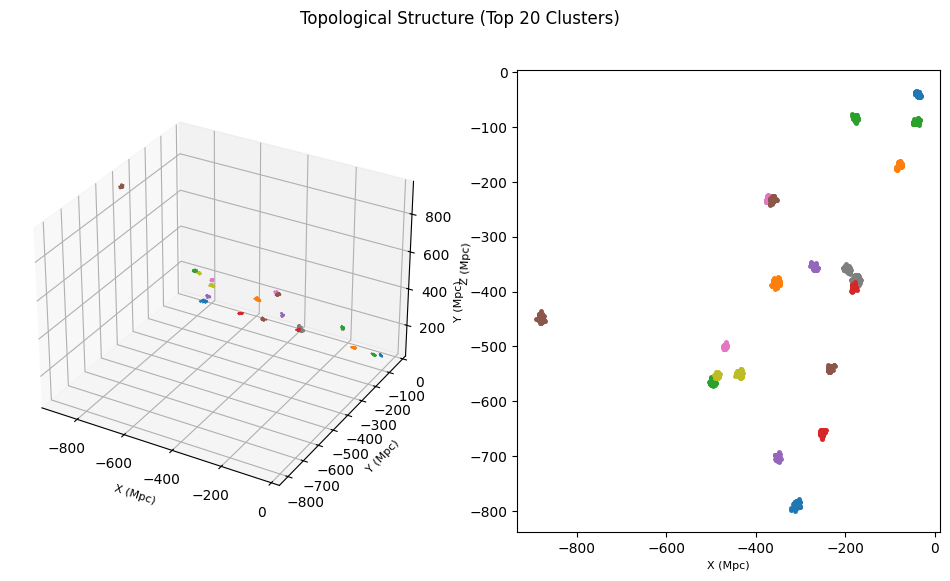

In [36]:
# NOTE: Plotting all 36,000 groups will crash the kernel.
# We limit to the top 20 largest clusters for this visualization.
unique_ids, counts = np.unique(links[:, 2], return_counts=True)
top_clusters = unique_ids[np.argsort(-counts)][:20]

fig = plt.figure(figsize=(12,6))

# Subplot 1: 3D View
ax = fig.add_subplot(121, projection='3d')
for i in top_clusters:
    i = int(i)
    # Filter for links belonging to cluster 'i'
    cluster_links = links[links[:,2]==i]
    
    for id_gals in cluster_links:
        id_gals = id_gals.astype(int)[:2]
        ax.plot(x[id_gals], y[id_gals], z[id_gals], 
                c=f'C{i%10}', lw=1, markersize=1, rasterized=True)
        
    ax.set_xlabel('X (Mpc)', fontsize=8)
    ax.set_ylabel('Y (Mpc)', fontsize=8)
    ax.set_zlabel('Z (Mpc)', fontsize=8)

# Subplot 2: 2D Projection
ax = fig.add_subplot(122)
for i in top_clusters:
    i = int(i)
    cluster_links = links[links[:,2]==i]
    
    for id_gals in cluster_links:
        id_gals = id_gals.astype(int)[:2]
        ax.plot(x[id_gals], y[id_gals], 
                c=f'C{i%10}', lw=1, marker='.', markersize=5, rasterized=True)
        
    ax.set_xlabel('X (Mpc)', fontsize=8)
    ax.set_ylabel('Y (Mpc)', fontsize=8)

plt.suptitle("Topological Structure (Top 20 Clusters)")
plt.show()

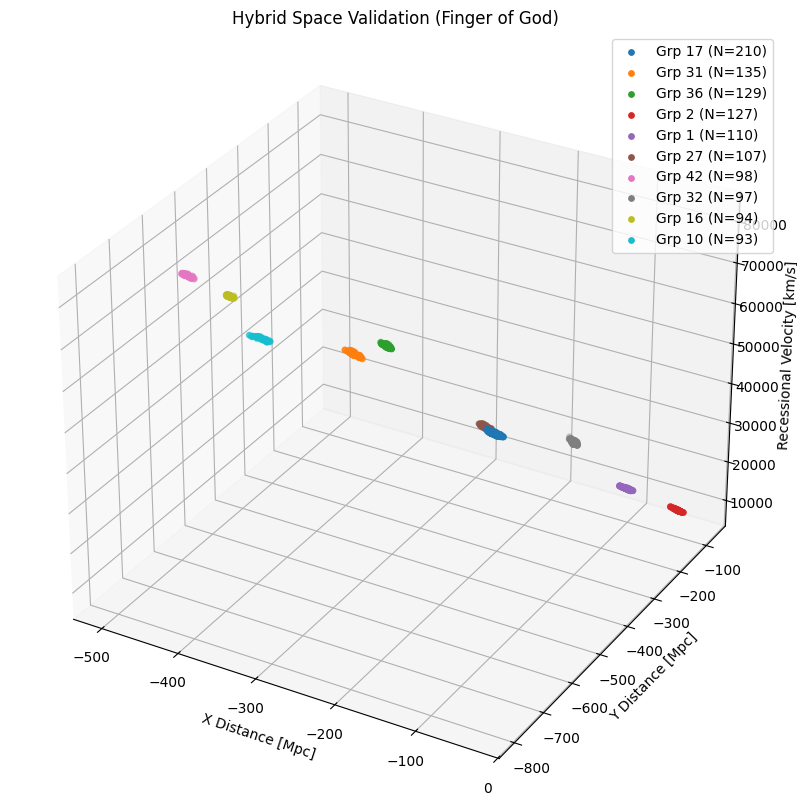

In [38]:
# This validates the physics (Z-axis = Velocity)
labels = MGS.get_label()
unique_lbls, counts = np.unique(labels, return_counts=True)
sorted_clusters = sorted(zip(unique_lbls, counts), key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot top 10 clusters in Hybrid Space
for i in range(10):
    lbl, n = sorted_clusters[i]
    if lbl == -1: continue
    
    mask = labels == lbl
    ax.scatter(x_clean[mask], y_clean[mask], z_vel_clean[mask], 
               s=15, label=f'Grp {lbl} (N={n})')

ax.set_xlabel("X Distance [Mpc]")
ax.set_ylabel("Y Distance [Mpc]")
ax.set_zlabel("Recessional Velocity [km/s]")
ax.set_title("Hybrid Space Validation (Finger of God)")
ax.set_box_aspect((1, 1, 0.8)) 
plt.legend()
plt.show()

In [40]:
# --- Calculate Topological Statistics ---
print("Calculating topological statistics...")
sta = time.time()

Totlength = []
for i in range(Nmgs):
    Totlength.append(MGS.Get_TotLength(i))

Generations = []
Length = []
nChild = []
nDegree = []
nBranch = []
OpenAngle = []
PolarAngle = []

for i in range(Nmgs):
    # 'cng[i]' is the count of galaxies/nodes in group i
    # We loop through nodes to get local properties
    for j in range(cng[i]):
        Generations.append(MGS.Get_generation(i,j))
        Length.append(MGS.Get_Length(i,j))
        nChild.append(MGS.Get_Child(i,j))
        nDegree.append(MGS.Get_Degree(i,j))
        # Note: Open/Polar Angle calculation might fail for isolated points, returning -1
        OpenAngle.append(MGS.Get_OpenAngle(i,j))
        PolarAngle.append(MGS.Get_LinkPolarAngle(i,j))
    
    # Branch count is per group
    nBranch.append(MGS.Get_Branch(i))

# Convert to arrays for masking
OpenAngle = np.asarray(OpenAngle)
PolarAngle = np.asarray(PolarAngle)
mask_open = np.where(OpenAngle >= 0)
mask_polar = np.where(PolarAngle >= 0)

end = time.time()
print(f"Topological stats calculated in {end - sta:.2f} seconds.")

Calculating topological statistics...
Topological stats calculated in 11.47 seconds.


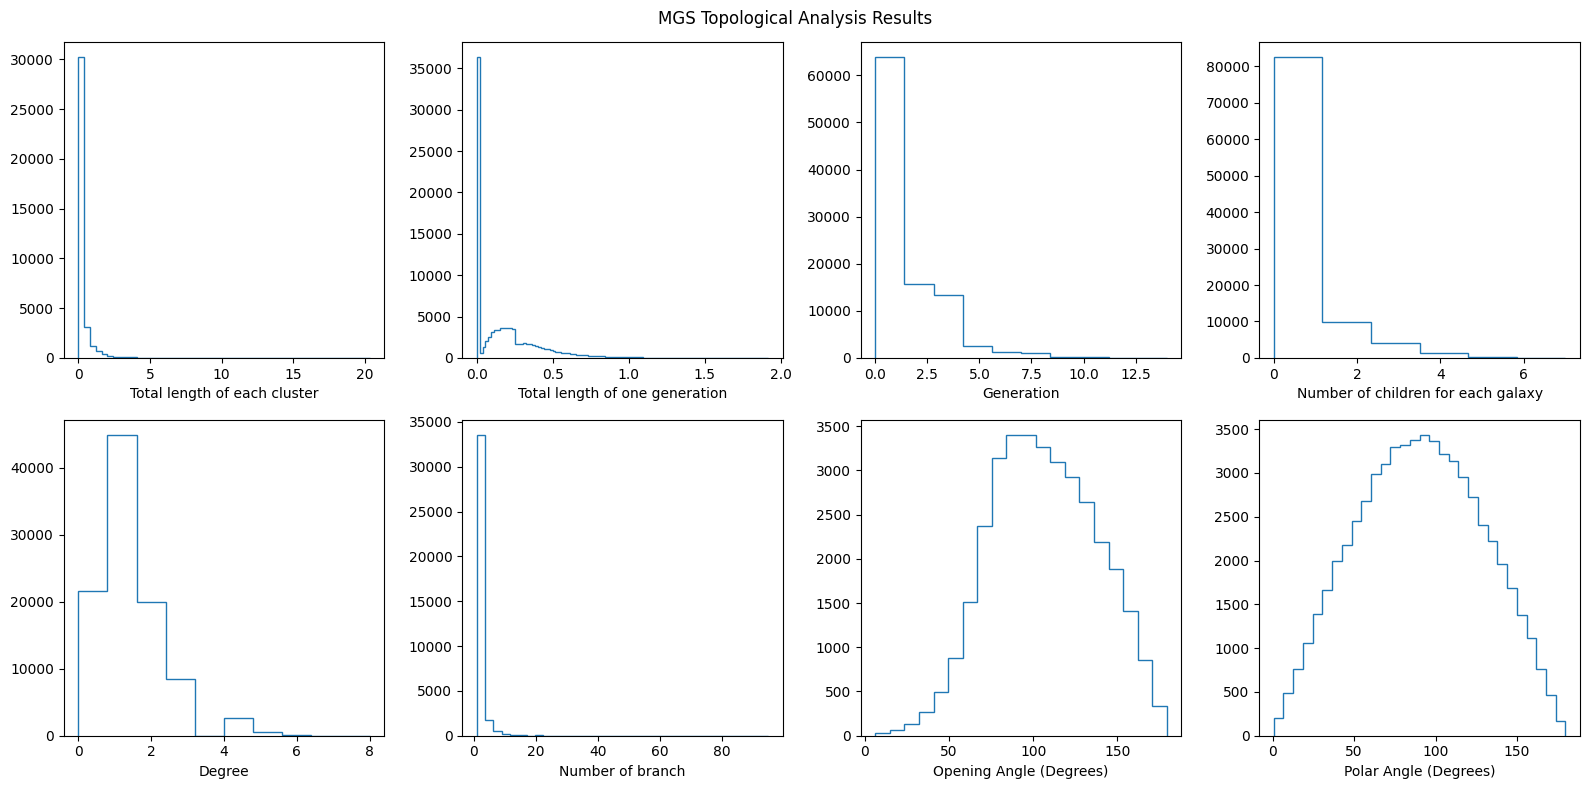

In [42]:
# --- Plot Histograms of Topological Properties ---
fig, ax = plt.subplots(2, 4, figsize=(16,8))

# Row 1
ax[0,0].hist(Totlength, histtype='step', bins=50)
ax[0,0].set_xlabel('Total length of each cluster')

ax[0,1].hist(Length, bins=100, histtype='step')
ax[0,1].set_xlabel('Total length of one generation')

ax[0,2].hist(Generations, histtype='step')
ax[0,2].set_xlabel('Generation')

ax[0,3].hist(nChild, bins=6, histtype='step')
ax[0,3].set_xlabel('Number of children for each galaxy')

# Row 2
ax[1,0].hist(nDegree, histtype='step')
ax[1,0].set_xlabel('Degree')

ax[1,1].hist(nBranch, bins=35, histtype='step')
ax[1,1].set_xlabel('Number of branch')

ax[1,2].hist(OpenAngle[mask_open]*(180./np.pi), bins=20, histtype='step')
ax[1,2].set_xlabel('Opening Angle (Degrees)')

ax[1,3].hist(PolarAngle[mask_polar]*(180./np.pi), bins=30, histtype='step')
ax[1,3].set_xlabel('Polar Angle (Degrees)')

plt.suptitle("MGS Topological Analysis Results")
plt.tight_layout()
plt.show()